In [2]:
%matplotlib inline
%config InlineBackend.figure_format = "svg"

# Logistic 回归与支持向量机实现与比较
## Logistic 回归

### 对`logistic_data1.csv`数据集画出分类平面（直线）。

1. 输出原始数据

In [3]:
import os
import pandas as pd
import torch
from IPython.display import clear_output, display

data_file = os.path.join('.', 'logistic_data1.csv')
data = pd.read_csv(data_file, )
# data
print(data)

           x0         x1  y
0   34.623660  78.024693  0
1   30.286711  43.894998  0
2   35.847409  72.902198  0
3   60.182599  86.308552  1
4   79.032736  75.344376  1
..        ...        ... ..
95  83.489163  48.380286  1
96  42.261701  87.103851  1
97  99.315009  68.775409  1
98  55.340018  64.931938  1
99  74.775893  89.529813  1

[100 rows x 3 columns]


2. 画出原始图像

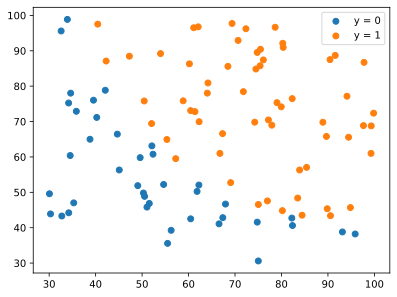

In [4]:
import matplotlib.pyplot as plt

data_0 = data[data['y']==0]
data_1 = data[data['y']==1]

plt.scatter(data_0['x0'], data_0['x1'], c='#1f77b4')  # blue
plt.scatter(data_1['x0'], data_1['x1'], c='#ff7f0e')  # orange
plt.legend(['y = 0', 'y = 1'])

plt.show()

3. 实现logistic回归模型

In [5]:
def scale(data):
    max,_ = torch.max(data, dim=0)
    min,_ = torch.min(data, dim=0)
    a = max - min
    b = torch.mean(data, dim=0)
    scale_data = (data-b)/a
    scale_data[:, -1] = data[:, -1]
    # print(self.scale_data)
    return scale_data

In [6]:
# 创建模型
class logistics: 
    def __init__(self, input_size, output_size, data):
        self.w = torch.rand(input_size, dtype=torch.float64) # 创建线性权重参数并视为列向量 (2)
        self.b = torch.rand(output_size, dtype=torch.float64) # 创建线性偏置参数 (1)
        self.input_size = input_size # (100,2)
        self.output_size = output_size # (100,1)
        self.input = data[:, :self.input_size]
        self.output = data[:, (-self.output_size):]
        self.data = data
        self.scale_data = data
    
    def linear(self): # data:(100,3)
        z = torch.sum(self.input * self.w, dim=1, keepdim=True) + self.b # (100)
        return z
    
    def sigmoid(self):
        z = self.linear()
        y = 1/(1+torch.exp(-z)) # sigmoid函数 (100)
        return y
    
    def loss(self):
        y = self.sigmoid()
        output = self.output.to(dtype=torch.int)
        one = torch.ones((output.shape[0], output.shape[1]), dtype=torch.int)
        
        epsilon = 1e-14  # 使用小常数防止出现nan
        y = torch.clamp(y, epsilon, 1.0 - epsilon)

        target = output*torch.log(y) + (one-output)*torch.log(one - y) # 最大化目标函数

        loss = -torch.mean(target, dim=0) # 转为凸优化问题
        return loss

    def grad(self):
        y = self.sigmoid()
        y = y.view(self.output.shape[0], self.output.shape[1]) # (100)-->(100,1)
        grad_w = -(self.output-y)*self.input # 梯度为loss的偏导 (100,1)*(100,2)=(100,2) 第一个张量的列依次乘第二个张量的列
        grad_b = -(self.output-y) # (100,1)
        return torch.mean(grad_w, dim=0), torch.mean(grad_b, dim=0) # 按第一维取平均(取平均之后第一维消失)
    
    def learn(self, lr):
        grad_w, grad_b = self.grad()
        self.w = self.w - grad_w*lr # 凸优化问题(开口向上)用减进行梯度回传
        self.b = self.b - grad_b*lr
        return self.w, self.b
    
    def L2_learn(self, lr, weight):
        grad_w, grad_b = self.grad()
        grad_w = grad_w + weight*torch.mean(self.w)
        self.w = self.w - grad_w*lr # 凸优化问题(开口向上)用减进行梯度回传
        self.b = self.b - grad_b*lr
        return self.w, self.b

# losses = []  # 用于存储损失值的列表
# for i in range(2000): # 10,6000
#     model.learn(100)
#     loss = model.loss()
#     if i % 100 == 0:
#         losses.append(loss)  # 记录损失值
#     if i % 1000 == 0:
#         # 实时更新图形
#         # 实时更新图形
#         clear_output(wait=True)
#         plt.plot(losses, color='blue')  # 保持蓝色
#         plt.xlabel('Epoch')
#         plt.ylabel('Loss')
#         plt.title('Loss Over Time')
#         display(plt.gcf())  # 显示图形

4. 训练并绘制决策边界

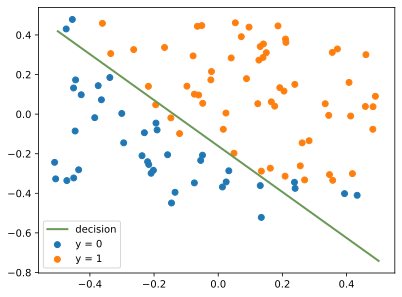

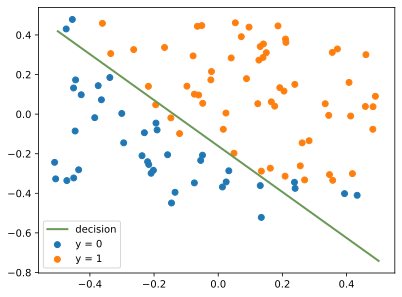

In [7]:
expert_data1 = torch.tensor(data.values)
expert_data2 = scale(expert_data1)
model_scale = logistics(2, 1, expert_data2)

for i in range(1000):
    model_scale.learn(0.1)
    if i % 100 == 0:
        clear_output(wait=True) # 清除当前输出并等待新输出的显示
        plt.clf()  # 清除上一次plt的图形
        # 决策边界：model.w[0]*x[0] + model.w[1]*x[1] + model.b = 0 --> x[1] = -(model.b + model.w[0]*x[0])/model.w[1]
        x = [-0.5, 0.5]  # x轴上的两点
        y = [ -(model_scale.b.item() + model_scale.w[0].item()*x[0])/model_scale.w[1].item(), -(model_scale.b.item() + model_scale.w[0].item()*x[1])/model_scale.w[1].item()]  # 对应的y值
        # 绘制直线
        plt.plot(x, y, color='#6a9956', linewidth=2)

        features = model_scale.data[:, :2]
        labels = model_scale.data[:, 2]
        class_0 = features[labels == 0]
        class_1 = features[labels == 1]
        plt.scatter(class_0[:, 0], class_0[:, 1], c='#1f77b4')  # blue
        plt.scatter(class_1[:, 0], class_1[:, 1], c='#ff7f0e')  # orange
        plt.legend(['decision', 'y = 0', 'y = 1'])
        display(plt.gcf())  # 显示图形

### 对`logistic_data2.csv`数据集，用`x0`, `x1`构造高阶特征。画出 Logistic 回归的分类曲线。

1. 画出原始图像

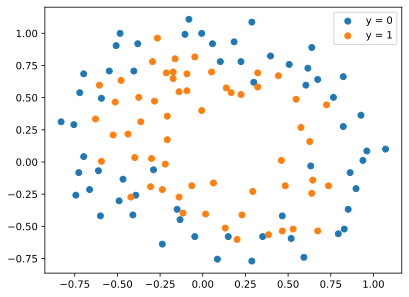

In [8]:
data_file = os.path.join('.', 'logistic_data2.csv')
data = pd.read_csv(data_file, )

data_0 = data[data['y']==0]
data_1 = data[data['y']==1]

plt.scatter(data_0['x0'], data_0['x1'], c='#1f77b4')  # blue
plt.scatter(data_1['x0'], data_1['x1'], c='#ff7f0e')  # orange
plt.legend(['y = 0', 'y = 1'])

plt.show()

2. 重构数据集，并绘制分类曲线

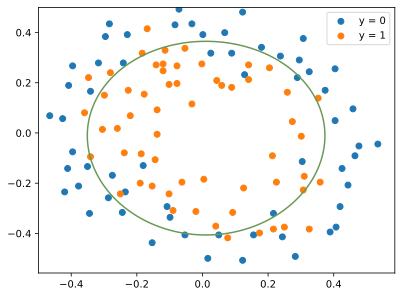

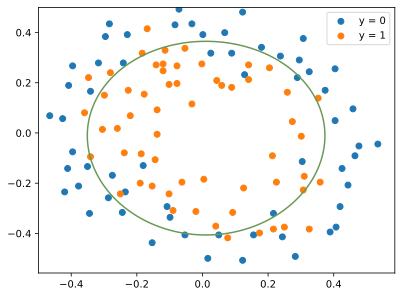

In [9]:
import numpy as np

expert_data1 = torch.tensor(data.values)
expert_data1 = scale(expert_data1)
expert_data3 = torch.ones((118, 7))
expert_data3[:, :2] = expert_data1[:, :2]
expert_data3[:, 2:4] = expert_data1[:, :2]*expert_data1[:, :2]
expert_data3[:, 4:6] = expert_data1[:, :2]*expert_data1[:, :2]*expert_data1[:, :2]
expert_data3[:, -1] = expert_data1[:, -1]


model_high = logistics(6, 1, expert_data3)

for i in range(20000):
    model_high.learn(0.3)
    if i % 1000 == 0:
        clear_output(wait=True) # 清除当前输出并等待新输出的显示
        plt.clf()  # 清除上一次plt的图形
        
        # 生成一系列x和y值
        x1 = np.linspace(-0.5, 0.5, 100)
        x2 = np.linspace(-0.5, 0.5, 100)

        # 创建网格点
        X1, X2 = np.meshgrid(x1, x2)

        Z = model_high.w[0].item()*X1 + model_high.w[1].item()*X2 + model_high.w[2].item()*X1**2 + model_high.w[3].item()*X2**2 + model_high.w[4].item()*X1**3 + model_high.w[5].item()*X2**3 + model_high.b.item()

        # 绘制曲线
        plt.contour(X1, X2, Z, levels=[0], colors='#6a9956')

        features = model_high.data[:, :2]
        labels = model_high.data[:, -1]
        class_0 = features[labels == 0]
        class_1 = features[labels == 1]
        plt.scatter(class_0[:, 0], class_0[:, 1], c='#1f77b4')  # blue
        plt.scatter(class_1[:, 0], class_1[:, 1], c='#ff7f0e')  # orange
        plt.legend(['y = 0', 'y = 1'])
        display(plt.gcf())  # 显示图形


3. 加入 L2 正则化，然后重新画出分类曲线。

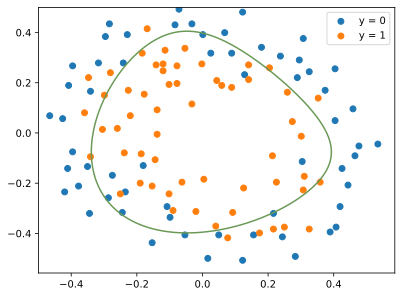

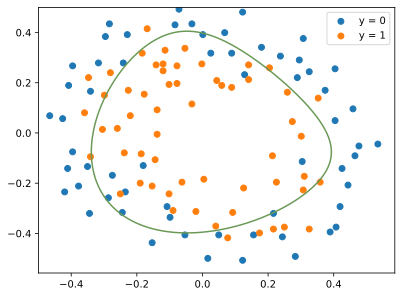

In [17]:
model_high = logistics(6, 1, expert_data3)

for i in range(50000):
    model_high.L2_learn(0.3, 0.5)
    if i % 1000 == 0:
        clear_output(wait=True) # 清除当前输出并等待新输出的显示
        plt.clf()  # 清除上一次plt的图形
        
        # 生成一系列x和y值
        x1 = np.linspace(-0.5, 0.5, 100)
        x2 = np.linspace(-0.5, 0.5, 100)

        # 创建网格点
        X1, X2 = np.meshgrid(x1, x2)

        Z = model_high.w[0].item()*X1 + model_high.w[1].item()*X2 + model_high.w[2].item()*X1**2 + model_high.w[3].item()*X2**2 + model_high.w[4].item()*X1**3 + model_high.w[5].item()*X2**3 + model_high.b.item()

        # 绘制曲线
        plt.contour(X1, X2, Z, levels=[0], colors='#6a9956')

        features = model_high.data[:, :2]
        labels = model_high.data[:, -1]
        class_0 = features[labels == 0]
        class_1 = features[labels == 1]
        plt.scatter(class_0[:, 0], class_0[:, 1], c='#1f77b4')  # blue
        plt.scatter(class_1[:, 0], class_1[:, 1], c='#ff7f0e')  # orange
        plt.legend(['y = 0', 'y = 1'])
        display(plt.gcf())  # 显示图形

## 支持向量机

请实现SVM，对`svm_data1.csv`数据集，画出分类平面（直线）。观察超参数对分类面的影响（注意`y=1`类别中的明显远离这个类别其他的点的点）。

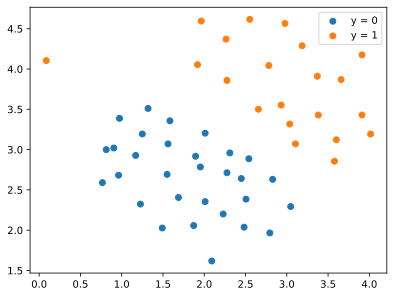

In [ ]:
data_file = os.path.join('.', 'svm_data1.csv')
data = pd.read_csv(data_file, )

data_0 = data[data['y']==0]
data_1 = data[data['y']==1]

plt.scatter(data_0['x0'], data_0['x1'], c='#1f77b4')  # blue
plt.scatter(data_1['x0'], data_1['x1'], c='#ff7f0e')  # orange
plt.legend(['y = 0', 'y = 1'])

plt.show()

请实现高斯核支持向量机，对`svm_data2.csv`和`svm_data3.csv`进行分类，并画出分类曲线。

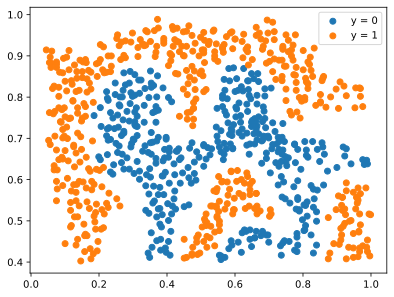

In [ ]:
data_file = os.path.join('.', 'svm_data2.csv')
data = pd.read_csv(data_file, )

data_0 = data[data['y']==0]
data_1 = data[data['y']==1]

plt.scatter(data_0['x0'], data_0['x1'], c='#1f77b4')  # blue
plt.scatter(data_1['x0'], data_1['x1'], c='#ff7f0e')  # orange
plt.legend(['y = 0', 'y = 1'])

plt.show()

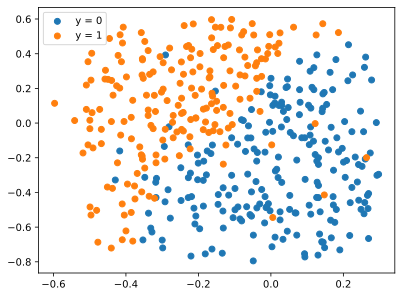

In [ ]:
data_file = os.path.join('.', 'svm_data3.csv')
data = pd.read_csv(data_file, )

data_0 = data[data['y']==0]
data_1 = data[data['y']==1]

plt.scatter(data_0['x0'], data_0['x1'], c='#1f77b4')  # blue
plt.scatter(data_1['x0'], data_1['x1'], c='#ff7f0e')  # orange
plt.legend(['y = 0', 'y = 1'])

plt.show()